In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import doubleml as dml
from doubleml.datasets import make_irm_data_discrete_treatments

In [2]:
# Parameters
n_obs = 1000
n_levels = 5
linear = False
n_rep = 1

np.random.seed(42)
data_apo = make_irm_data_discrete_treatments(n_obs=n_obs,n_levels=n_levels, linear=linear)

y0 = data_apo['oracle_values']['y0']
cont_d = data_apo['oracle_values']['cont_d']
ite = data_apo['oracle_values']['ite']
d = data_apo['d']
potential_level = data_apo['oracle_values']['potential_level']
level_bounds = data_apo['oracle_values']['level_bounds']

average_ites = np.full(n_levels + 1, np.nan)
apos = np.full(n_levels + 1, np.nan)
mid_points = np.full(n_levels, np.nan)

for i in range(n_levels + 1):
    average_ites[i] = np.mean(ite[d == i]) * (i > 0)
    apos[i] = np.mean(y0) + average_ites[i]

print(f"Average treatment effects in each group:\n{np.round(average_ites,2)}\n")
print(f"Average potential outcomes in each group:\n{np.round(apos,2)}\n")
print(f"Levels and their counts:\n{np.unique(d, return_counts=True)}")

Average treatment effects in each group:
[ 0.    1.46  6.67  9.31 10.36 10.47]

Average potential outcomes in each group:
[209.9  211.36 216.56 219.2  220.26 220.37]

Levels and their counts:
(array([0., 1., 2., 3., 4., 5.]), array([183, 165, 154, 162, 175, 161]))


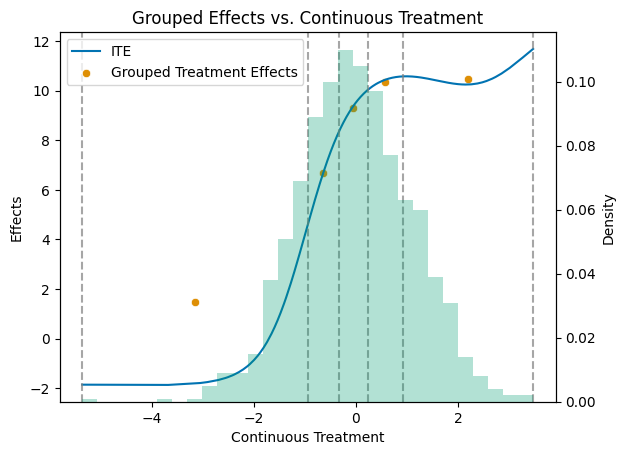

In [3]:
# Get a colorblind-friendly palette
palette = sns.color_palette("colorblind")

df = pd.DataFrame({'cont_d': cont_d, 'ite': ite})
df_sorted = df.sort_values('cont_d')

mid_points = np.full(n_levels, np.nan)
for i in range(n_levels):
    mid_points[i] = (level_bounds[i] + level_bounds[i + 1]) / 2

df_apos = pd.DataFrame({'mid_points': mid_points, 'treatment effects': apos[1:] - apos[0]})

# Create the primary plot with scatter and line plots
fig, ax1 = plt.subplots()

sns.lineplot(data=df_sorted, x='cont_d', y='ite', color=palette[0], label='ITE', ax=ax1)
sns.scatterplot(data=df_apos, x='mid_points', y='treatment effects', color=palette[1], label='Grouped Treatment Effects', ax=ax1)

# Add vertical dashed lines at level_bounds
for bound in level_bounds:
    ax1.axvline(x=bound, color='grey', linestyle='--', alpha=0.7)

ax1.set_title('Grouped Effects vs. Continuous Treatment')
ax1.set_xlabel('Continuous Treatment')
ax1.set_ylabel('Effects')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot the histogram on the secondary y-axis
ax2.hist(df_sorted['cont_d'], bins=30, alpha=0.3, weights=np.ones_like(df_sorted['cont_d']) / len(df_sorted['cont_d']), color=palette[2])
ax2.set_ylabel('Density')

# Make sure the legend includes all plots
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

plt.show()

In [4]:
y = data_apo['y']
x = data_apo['x']
d = data_apo['d']
df_apo = pd.DataFrame(
    np.column_stack((y, d, x)),
    columns=['y', 'd'] + ['x' + str(i) for i in range(data_apo['x'].shape[1])]
)

dml_data = dml.DoubleMLData(df_apo, 'y', 'd')
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['x0', 'x1', 'x2', 'x3', 'x4']
Instrument variable(s): None
No. Observations: 1000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 7 entries, y to x4
dtypes: float64(7)
memory usage: 54.8 KB



In [5]:
# Define a dictionary of learner combinations
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import lightgbm as lgbm
from tabpfn import TabPFNRegressor, TabPFNClassifier

device = 'cuda'
learner_dict = {
    'RandomForest': {
        'ml_g': RandomForestRegressor(),
        'ml_m': RandomForestClassifier()
    },
    'Linear': {
        'ml_g': LinearRegression(),
        'ml_m': LogisticRegression(max_iter=1000)
    },
    'LightGBM': {
        'ml_g': lgbm.LGBMRegressor(n_estimators=50, verbose=-1),
        'ml_m': lgbm.LGBMClassifier(n_estimators=50, verbose=-1)
    },
    'TabPFN': {
        'ml_g': TabPFNRegressor(device=device),
        'ml_m': TabPFNClassifier(device=device)
    }
}

In [6]:
# Estimate causal contrasts (ATEs) for all models (difference to reference level 0)
treatment_levels = np.unique(dml_data.d)
reference_level = 0

apo_results = []
causal_contrast_results = []
model_list = []

for learner_name, learner_pair in learner_dict.items():
    # Recreate dml_obj for each learner (as in the main loop)
    dml_obj = dml.DoubleMLAPOS(
        dml_data,
        learner_pair['ml_g'],
        learner_pair['ml_m'],
        treatment_levels=treatment_levels,
        n_rep=n_rep,
    )
    dml_obj.fit()
    model_list.append(dml_obj)

    # APO confidence intervals
    ci_pointwise = dml_obj.confint(level=0.95)
    df_apos = pd.DataFrame({
        'learner': learner_name,
        'treatment_level': treatment_levels,
        'apo': dml_obj.coef,
        'ci_lower': ci_pointwise.values[:, 0],
        'ci_upper': ci_pointwise.values[:, 1]}
    )
    apo_results.append(df_apos)

    # ATE confidence intervals
    causal_contrast_model = dml_obj.causal_contrast(reference_levels=reference_level)
    ates = causal_contrast_model.thetas
    ci_ates = causal_contrast_model.confint(level=0.95)
    df_ates = pd.DataFrame({
        'learner': learner_name,
        'treatment_level': treatment_levels[1:],
        'ate': ates,
        'ci_lower': ci_ates.iloc[:, 0].values,
        'ci_upper': ci_ates.iloc[:, 1].values
    })
    causal_contrast_results.append(df_ates)

# Combine all results
df_all_apos = pd.concat(apo_results, ignore_index=True)
df_all_ates = pd.concat(causal_contrast_results, ignore_index=True)
df_all_ates

c:\Users\svenk\anaconda3\envs\dml_tabpfn\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\svenk\anaconda3\envs\dml_tabpfn\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\svenk\anaconda3\envs\dml_tabpfn\Lib\site-packages\doubleml\double_ml.py:1479: UserWarning: The estimated nu2 for d is not positive. Re-estimation based on riesz representer (non-orthogonal).
  warnings.warn(msg, UserWarning)
c:\Users\svenk\anaconda3\envs\dml_tabpfn\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\svenk\anaconda3\envs\dml_tabpfn\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finit

,learner,treatment_level,ate,ci_lower,ci_upper
0,RandomForest,1.0,2.744951,-5.657416,11.147319
1,RandomForest,2.0,4.550421,-1.794276,10.895118
2,RandomForest,3.0,10.640574,4.320402,16.960747
3,RandomForest,4.0,9.315172,3.212198,15.418145
4,RandomForest,5.0,11.857786,2.759284,20.956289
5,Linear,1.0,3.709369,-1.784583,9.203320
6,Linear,2.0,8.231820,3.262753,13.200887
7,Linear,3.0,10.332460,6.498161,14.166758
8,Linear,4.0,11.406049,7.861799,14.950299
9,Linear,5.0,7.050111,3.434561,10.665662


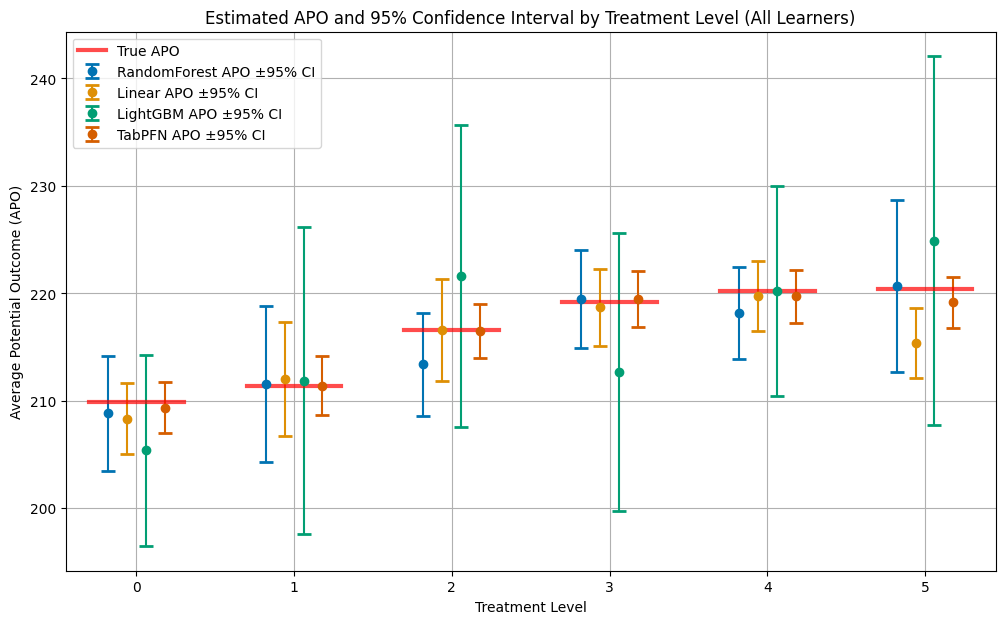

In [7]:
# Plot APOs and 95% CIs for all models
plt.figure(figsize=(12, 7))
palette = sns.color_palette("colorblind")
learners = df_all_apos['learner'].unique()
n_learners = len(learners)
jitter_strength = 0.12

for i, learner in enumerate(learners):
    df = df_all_apos[df_all_apos['learner'] == learner]
    # Jitter x positions for each learner
    jitter = (i - (n_learners - 1) / 2) * jitter_strength
    x_jittered = df['treatment_level'] + jitter
    plt.errorbar(
        x_jittered,
        df['apo'],
        yerr=[df['apo'] - df['ci_lower'], df['ci_upper'] - df['apo']],
        fmt='o',
        capsize=5,
        capthick=2,
        ecolor=palette[i % len(palette)],
        color=palette[i % len(palette)],
        label=f"{learner} APO ±95% CI",
        zorder=2
    )

# Get treatment levels for proper line positioning
treatment_levels = sorted(df_all_apos['treatment_level'].unique())
x_range = plt.xlim()
total_width = x_range[1] - x_range[0]

# Add true APOs as red horizontal lines
for i, level in enumerate(treatment_levels):
    # Center each line around its treatment level with a reasonable width
    line_width = 0.6  # Width of each horizontal line relative to treatment level spacing
    x_center = level
    x_start = x_center - line_width/2
    x_end = x_center + line_width/2
    
    # Convert to relative coordinates (0-1) for xmin/xmax
    xmin_rel = max(0, (x_start - x_range[0]) / total_width)
    xmax_rel = min(1, (x_end - x_range[0]) / total_width)
    
    plt.axhline(y=apos[int(level)], color='red', linestyle='-', alpha=0.7, 
                xmin=xmin_rel, xmax=xmax_rel,
                linewidth=3, label='True APO' if i == 0 else "")

plt.title('Estimated APO and 95% Confidence Interval by Treatment Level (All Learners)')
plt.xlabel('Treatment Level')
plt.ylabel('Average Potential Outcome (APO)')
plt.xticks(sorted(df_all_apos['treatment_level'].unique()))
plt.legend()
plt.grid(True)
plt.show()

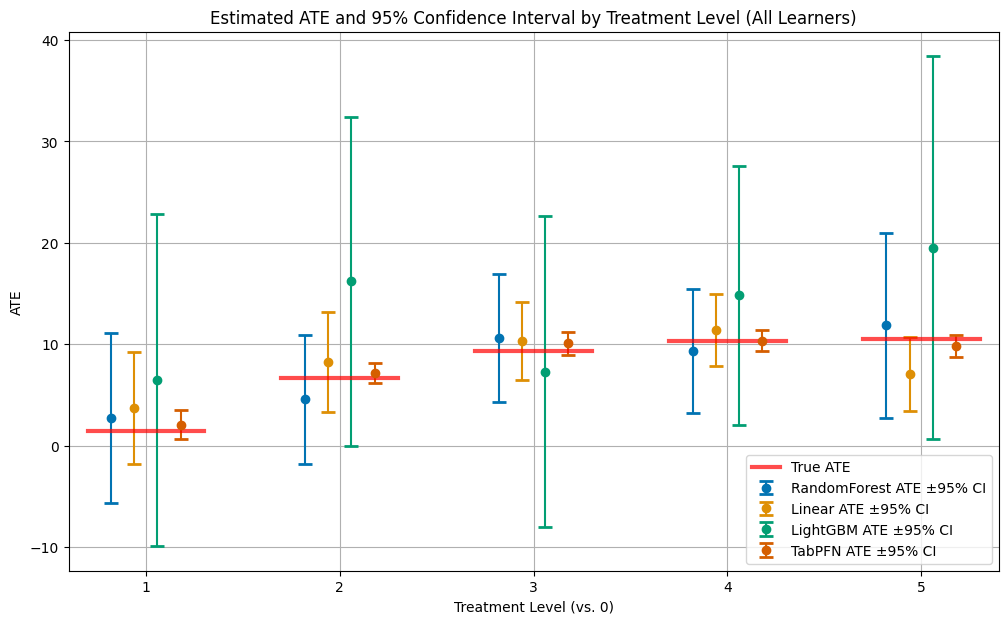

In [8]:
# Plot ATEs and 95% CIs for all models
plt.figure(figsize=(12, 7))
palette = sns.color_palette("colorblind")
learners = df_all_ates['learner'].unique()
n_learners = len(learners)
jitter_strength = 0.12

for i, learner in enumerate(learners):
    df = df_all_ates[df_all_ates['learner'] == learner]
    # Jitter x positions for each learner
    jitter = (i - (n_learners - 1) / 2) * jitter_strength
    x_jittered = df['treatment_level'] + jitter
    plt.errorbar(
        x_jittered,
        df['ate'],
        yerr=[df['ate'] - df['ci_lower'], df['ci_upper'] - df['ate']],
        fmt='o',
        capsize=5,
        capthick=2,
        ecolor=palette[i % len(palette)],
        color=palette[i % len(palette)],
        label=f"{learner} ATE ±95% CI",
        zorder=2
    )

# Get treatment levels for proper line positioning
treatment_levels = sorted(df_all_ates['treatment_level'].unique())
x_range = plt.xlim()
total_width = x_range[1] - x_range[0]

# Add true ATEs as red horizontal lines
for i, level in enumerate(treatment_levels):
    # Center each line around its treatment level with a reasonable width
    line_width = 0.6  # Width of each horizontal line relative to treatment level spacing
    x_center = level
    x_start = x_center - line_width/2
    x_end = x_center + line_width/2
    
    # Convert to relative coordinates (0-1) for xmin/xmax
    xmin_rel = max(0, (x_start - x_range[0]) / total_width)
    xmax_rel = min(1, (x_end - x_range[0]) / total_width)
    
    # Use average_ites[level] for the true ATE (treatment levels start from 1 for ATEs)
    plt.axhline(y=average_ites[int(level)], color='red', linestyle='-', alpha=0.7, 
                xmin=xmin_rel, xmax=xmax_rel,
                linewidth=3, label='True ATE' if i == 0 else "")

plt.title('Estimated ATE and 95% Confidence Interval by Treatment Level (All Learners)')
plt.xlabel('Treatment Level (vs. 0)')
plt.ylabel('ATE')
plt.xticks(sorted(df_all_ates['treatment_level'].unique()))
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Create a comprehensive table with RMSE for g0, g1 and log loss for all learners and treatment levels
performance_results = []

for idx_learner, learner_name in enumerate(learner_dict.keys()):
    for idx_treat, treatment_level in enumerate(treatment_levels):
        # Get the specific model for this learner and treatment level
        model = model_list[idx_learner].modellist[idx_treat]
        
        # Extract performance metrics from nuisance_loss
        if model.nuisance_loss is not None:
            # RMSE for g0 (outcome model for treatment level != d)
            rmse_g0 = model.nuisance_loss['ml_g_d_lvl0'][0][0]
            
            # RMSE for g1 (outcome model for treatment level = d)
            rmse_g1 = model.nuisance_loss['ml_g_d_lvl1'][0][0]
            
            # Log loss for propensity score model
            logloss_m = model.nuisance_loss['ml_m'][0][0]
        else:
            rmse_g0 = rmse_g1 = logloss_m = None
        
        # Store results
        performance_results.append({
            'Learner': learner_name,
            'Treatment_Level': treatment_level,
            'RMSE_g0': rmse_g0,
            'RMSE_g1': rmse_g1,
            'LogLoss_m': logloss_m
        })

# Create DataFrame and display as a nicely formatted table
df_performance = pd.DataFrame(performance_results)

# Round values for better readability
df_performance['RMSE_g0'] = df_performance['RMSE_g0'].round(4)
df_performance['RMSE_g1'] = df_performance['RMSE_g1'].round(4)
df_performance['LogLoss_m'] = df_performance['LogLoss_m'].round(4)

print("\n\nRMSE g0 by Learner and Treatment Level:")
print("=" * 80)
pivot_rmse_g0 = df_performance.pivot(index='Learner', columns='Treatment_Level', values='RMSE_g0')
print(pivot_rmse_g0.to_string())

print("\n\nRMSE g1 by Learner and Treatment Level:")
print("=" * 80)
pivot_rmse_g1 = df_performance.pivot(index='Learner', columns='Treatment_Level', values='RMSE_g1')
print(pivot_rmse_g1.to_string())

print("\n\nLogLoss m by Learner and Treatment Level:")
print("=" * 80)
pivot_logloss = df_performance.pivot(index='Learner', columns='Treatment_Level', values='LogLoss_m')
print(pivot_logloss.to_string())



RMSE g0 by Learner and Treatment Level:
Treatment_Level      1.0      2.0      3.0      4.0      5.0
Learner                                                     
LightGBM         15.0193  11.2384  15.1283  14.7045  14.3642
Linear           21.3597  17.3510  20.5465  21.0926  21.1883
RandomForest     14.7957  11.0708  15.0855  14.6947  14.9856
TabPFN            9.6678   3.0042   9.9569   9.8757   9.7987


RMSE g1 by Learner and Treatment Level:
Treatment_Level      1.0      2.0      3.0      4.0      5.0
Learner                                                     
LightGBM         16.5259  31.5894  20.1407  18.7611  16.3981
Linear           16.9486  29.5049  20.8541  17.9796  16.7760
RandomForest     14.7852  26.5536  19.5189  16.7581  16.0231
TabPFN            3.3231  19.0293   4.9100   5.7262   5.2918


LogLoss m by Learner and Treatment Level:
Treatment_Level     1.0     2.0     3.0     4.0     5.0
Learner                                                
LightGBM         0.5898  0.5

In [10]:
# Best performing learners for each metric
print("\nBest performing learners (averaged across treatment levels):")
print("-" * 60)

# Calculate average metrics across treatment levels for each learner
summary_stats = df_performance.groupby('Learner')[['RMSE_g0', 'RMSE_g1', 'LogLoss_m']].mean().round(4)
print(summary_stats)


Best performing learners (averaged across treatment levels):
------------------------------------------------------------
              RMSE_g0  RMSE_g1  LogLoss_m
Learner                                  
LightGBM      14.0909  20.6830     0.5457
Linear        20.3076  20.4126     0.4488
RandomForest  14.1265  18.7278     0.4860
TabPFN         8.4607   7.6561     0.4506
